In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load MovieLens datasets
movies = pd.read_csv("/Users/sarahberkin/Documents/DataScience/MovieRecommender/ml-latest-small/movies.csv")
ratings = pd.read_csv("/Users/sarahberkin/Documents/DataScience/MovieRecommender/ml-latest-small/ratings.csv")
tags = pd.read_csv("/Users/sarahberkin/Documents/DataScience/MovieRecommender/ml-latest-small/tags.csv")

In [5]:
# Display first few rows
print("Movies:\n", movies.head(), "\n")
print("Ratings:\n", ratings.head(), "\n")
print("Tags:\n", tags.head(), "\n")

Movies:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

Ratings:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

Tags:
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2  

In [7]:
# Check for missing values
print("Missing values in movies:\n", movies.isnull().sum(), "\n")
print("Missing values in ratings:\n", ratings.isnull().sum(), "\n")
print("Missing values in tags:\n", tags.isnull().sum(), "\n")

Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64 

Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

Missing values in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64 



In [9]:
# Check data types
print("Data types in movies:\n", movies.dtypes, "\n")
print("Data types in ratings:\n", ratings.dtypes, "\n")
print("Data types in tags:\n", tags.dtypes, "\n")

Data types in movies:
 movieId     int64
title      object
genres     object
dtype: object 

Data types in ratings:
 userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object 

Data types in tags:
 userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object 



In [11]:
#Checking how many ratings are between 1-2 to make sure we can simulate scrolling frustration
low_ratings = ratings[(ratings["rating"] >= 1.0) & (ratings["rating"] <= 2.0)]
low_rating_count = low_ratings.shape[0]
total_ratings_count = ratings.shape[0]
low_rating_percentage = (low_rating_count / total_ratings_count) * 100
print(f"Total Ratings: {total_ratings_count}")
print(f"Low Ratings (1-2): {low_rating_count}")
print(f"Percentage of Low Ratings: {low_rating_percentage:.2f}%")

Total Ratings: 100836
Low Ratings (1-2): 12153
Percentage of Low Ratings: 12.05%


In [13]:
#Checking data sparcity (if very low (<1%), collaborative filtering may struggle)
num_ratings = ratings.shape[0]
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()
total_possible_ratings = num_users * num_movies

sparsity = (num_ratings / total_possible_ratings) * 100
print(f"Data Sparsity: {sparsity:.5f}%")

Data Sparsity: 1.69997%


implicit_feedback
1    61.204332
0    38.795668
Name: proportion, dtype: float64


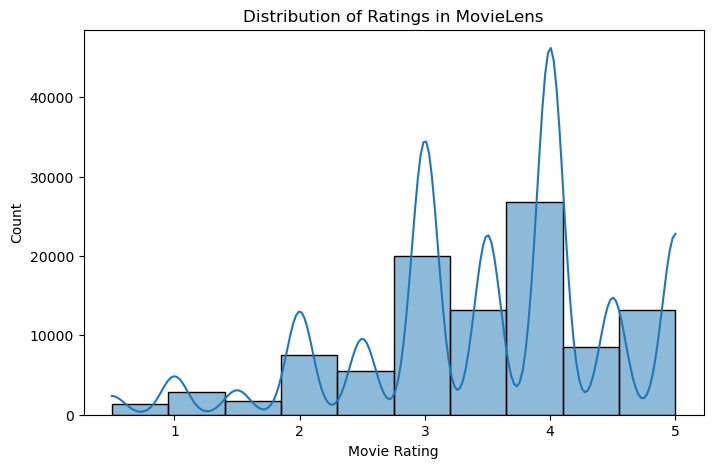

In [15]:
#Checking implicit ratings (if 90%+ feddback is "1", dataset may be unbalanced)
ratings["implicit_feedback"] = ratings["rating"].apply(lambda x: 1 if x >= 3.5 else 0)
print(ratings["implicit_feedback"].value_counts(normalize=True) * 100)

#Visualing rating distribution
plt.figure(figsize=(8,5))
sns.histplot(ratings["rating"], bins=10, kde=True)
plt.xlabel("Movie Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings in MovieLens")
plt.show()

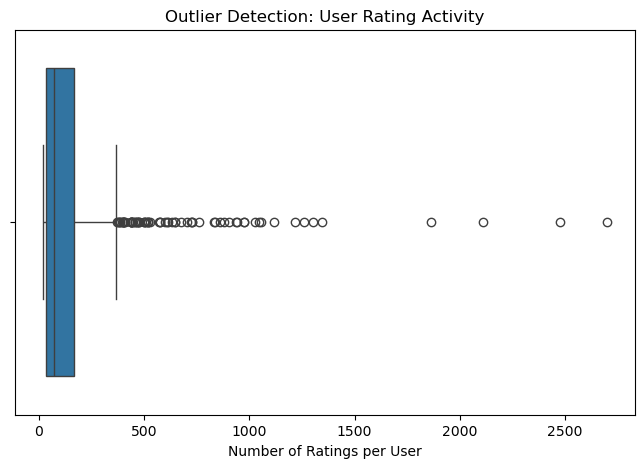

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64


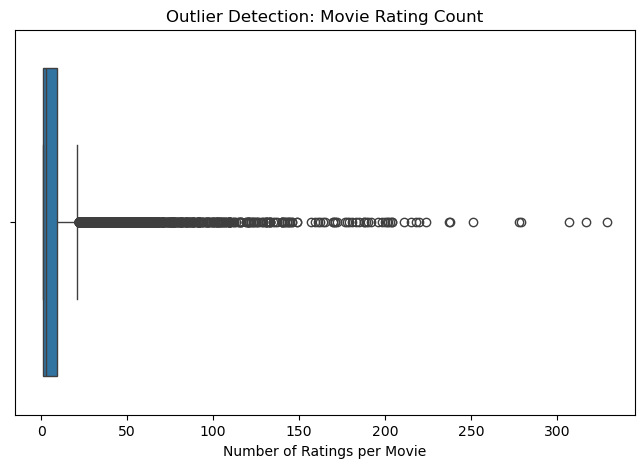

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count, dtype: float64


In [17]:
#Outliers

#Number ratings per user
user_rating_counts = ratings["userId"].value_counts()
plt.figure(figsize=(8,5))
sns.boxplot(x=user_rating_counts)
plt.xlabel("Number of Ratings per User")
plt.title("Outlier Detection: User Rating Activity")
plt.show()
print(user_rating_counts.describe())

#Number ratings per movie
movie_rating_counts = ratings["movieId"].value_counts()
plt.figure(figsize=(8,5))
sns.boxplot(x=movie_rating_counts)
plt.xlabel("Number of Ratings per Movie")
plt.title("Outlier Detection: Movie Rating Count")
plt.show()
print(movie_rating_counts.describe())

Upper Outlier Threshold: 367.5
Upper Outlier Threshold: 21.0


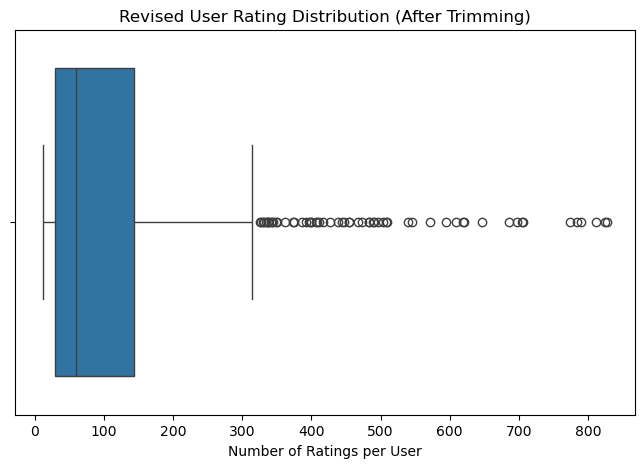

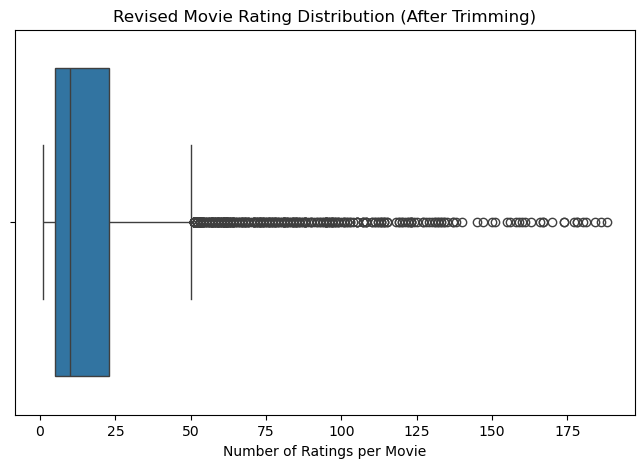

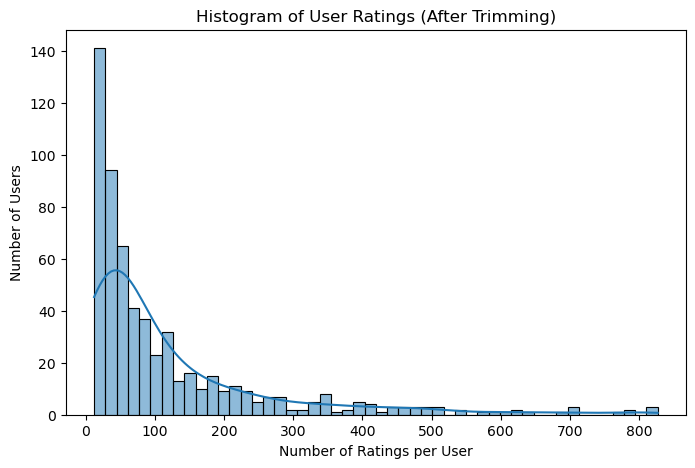

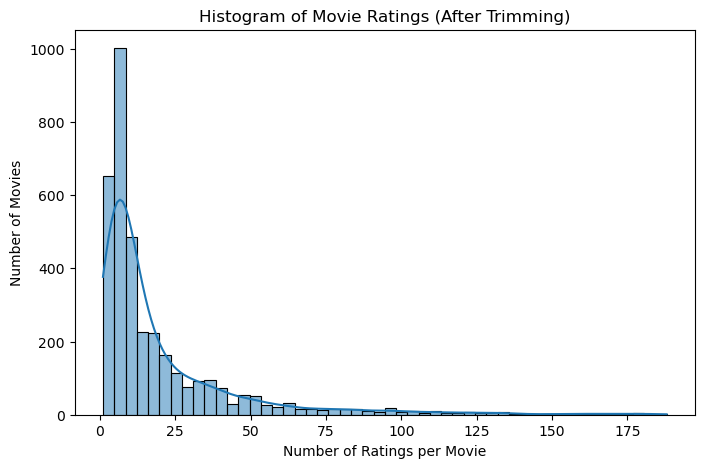

In [19]:
#Further look into outliers

#Number ratings per user IQR
Q1 = user_rating_counts.quantile(0.25)  # 25th percentile (35 ratings)
Q3 = user_rating_counts.quantile(0.75)  # 75th percentile (168 ratings)
IQR = Q3 - Q1

# Define upper limit for extreme users
upper_limit = Q3 + 1.5 * IQR
print(f"Upper Outlier Threshold: {upper_limit}")

#Moderate trimming
filtered_users = user_rating_counts[user_rating_counts <= 1000].index
ratings_filtered = ratings[ratings["userId"].isin(filtered_users)]

#Number ratings per movie IQR
Q1_movies = movie_rating_counts.quantile(0.25)  # 1 rating
Q3_movies = movie_rating_counts.quantile(0.75)  # 9 ratings
IQR_movies = Q3_movies - Q1_movies 

# Define upper bound for outliers
upper_limit_movies = Q3_movies + 1.5 * IQR_movies
print(f"Upper Outlier Threshold: {upper_limit_movies}")

#Moderate trimming
filtered_movies = movie_rating_counts[(movie_rating_counts >= 5) & (movie_rating_counts <= 200)].index
ratings_filtered = ratings_filtered[ratings_filtered["movieId"].isin(filtered_movies)]

#Revised visualizations
plt.figure(figsize=(8,5))
sns.boxplot(x=ratings_filtered["userId"].value_counts())
plt.xlabel("Number of Ratings per User")
plt.title("Revised User Rating Distribution (After Trimming)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=ratings_filtered["movieId"].value_counts())
plt.xlabel("Number of Ratings per Movie")
plt.title("Revised Movie Rating Distribution (After Trimming)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(ratings_filtered["userId"].value_counts(), bins=50, kde=True)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("Histogram of User Ratings (After Trimming)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(ratings_filtered["movieId"].value_counts(), bins=50, kde=True)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.title("Histogram of Movie Ratings (After Trimming)")
plt.show()

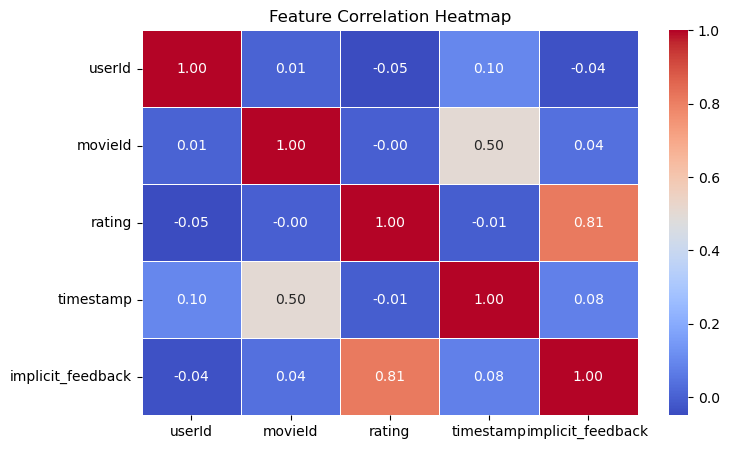

In [21]:
#Feature correlation Heatmap to see if feedback strongly correlates with ratings
correlation_matrix = ratings.corr()
plt.figure(figsize=(8,5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

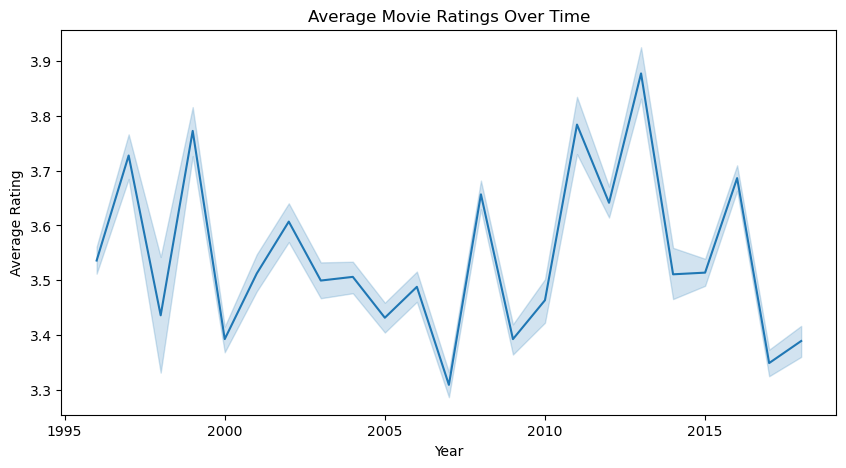

In [23]:
#Check if ratings are changing over time, older vs newer movies
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings["rating_year"] = ratings["timestamp"].dt.year
plt.figure(figsize=(10,5))
sns.lineplot(x="rating_year", y="rating", data=ratings, estimator="mean")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Movie Ratings Over Time")
plt.show()